In [2]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

archivos = {
    182: "WE__0182___________DER_PS__________________P01.CSV",
    361: "WE__0361___________DER_PS__________________P01.CSV",
    504: "WE__0504___________DER_PS__________________P01.CSV",
    658: "WE__0658___________DER_PS__________________P01.CSV",
}



In [3]:
# Función: convertir "HH:MM:SS" -> horas decimales (0–24)

def hhmmss_a_horas_decimales(hhmmss: str) -> float:
    """
    Convierte una cadena 'HH:MM:SS' en horas decimales.
    Ej: '01:30:00' -> 1.5
    """
    h, m, s = hhmmss.split(":")
    h = int(h); m = int(m); s = int(s)
    return h + m/60 + s/3600


In [4]:
# Función: leer un CSV de MEDA (DER) y preparar columnas clave
#          - extrae LTST en formato HH:MM:SS
#          - crea hora_decimal
#          - deja presión como float

def cargar_y_preparar_csv(sol: int, ruta_csv: str) -> pd.DataFrame:
    # Lectura "robusta" (por si hay variaciones en el CSV)
    df = pd.read_csv(ruta_csv)

    # Validaciones mínimas (según el enunciado: LTST y PRESSURE deben existir)
    columnas_necesarias = {"LTST", "PRESSURE"}
    faltan = columnas_necesarias - set(df.columns)
    if faltan:
        raise ValueError(f"En el archivo del sol {sol} faltan columnas: {faltan}. Columnas disponibles: {list(df.columns)}")

    # LTST viene tipo: "0182 00:14:47"  -> nos quedamos con "00:14:47"
    df["LTST_hora"] = df["LTST"].astype(str).str.split().str[-1]

    # Hora decimal
    df["hora_decimal"] = df["LTST_hora"].apply(hhmmss_a_horas_decimales)

    # Presión a numérico (por si viene como texto)
    df["PRESSURE"] = pd.to_numeric(df["PRESSURE"], errors="coerce")

    # Agregamos SOL por comodidad
    df["SOL"] = sol

    return df


In [5]:
# Cargar un sol (partimos con el 182) y verificar rápido

sol = 182
df182 = cargar_y_preparar_csv(sol, archivos[sol])

df182.head(), df182[["LTST", "LTST_hora", "hora_decimal", "PRESSURE"]].head()


(        SCLK                LMST           LTST  PRESSURE  \
 0  683051134  00182M00:00:00.924  0182 00:14:47    713.48   
 1  683051135  00182M00:00:01.897  0182 00:14:48    713.55   
 2  683051136  00182M00:00:02.871  0182 00:14:48    713.57   
 3  683051137  00182M00:00:03.844  0182 00:14:49    713.53   
 4  683051138  00182M00:00:04.817  0182 00:14:50    713.53   
 
    PRESSURE_UNCERTAINTY  TRANSDUCER LTST_hora  hora_decimal  SOL  
 0                   NaN           1  00:14:47      0.246389  182  
 1                   NaN           1  00:14:48      0.246667  182  
 2                   NaN           1  00:14:48      0.246667  182  
 3                   NaN           1  00:14:49      0.246944  182  
 4                   NaN           1  00:14:50      0.247222  182  ,
             LTST LTST_hora  hora_decimal  PRESSURE
 0  0182 00:14:47  00:14:47      0.246389    713.48
 1  0182 00:14:48  00:14:48      0.246667    713.55
 2  0182 00:14:48  00:14:48      0.246667    713.57
 3  0182 

In [6]:
# Construir la serie regular cada 5 minutos (ventanas) para 1 sol
#          - Recorre 0..24 en pasos de 5/60
#          - Calcula mean(PRESSURE) en cada ventana
#          - Si no hay datos en esa ventana => NaN

def promediar_cada_5min(df_sol: pd.DataFrame, sol: int, delta_min: int = 5) -> pd.DataFrame:
    delta_h = delta_min / 60.0
    bordes = np.arange(0, 24 + delta_h, delta_h)

    tiempos_centro = []
    medias = []

    for i in range(len(bordes) - 1):
        t_ini = bordes[i]
        t_fin = bordes[i + 1]

        mask = (df_sol["hora_decimal"] >= t_ini) & (df_sol["hora_decimal"] < t_fin)
        subset = df_sol.loc[mask, "PRESSURE"].dropna()

        mean_p = subset.mean() if len(subset) > 0 else np.nan
        t_centro = (t_ini + t_fin) / 2

        tiempos_centro.append(t_centro)
        medias.append(mean_p)

    out = pd.DataFrame({
        "SOL": sol,
        "LTST_horas": tiempos_centro,
        "PRESSURE_mean": medias
    })

    return out


In [7]:
# Ejecutar el promediado 5-min para el sol 182 y chequear tamaño

df182_5min = promediar_cada_5min(df182, sol=182, delta_min=5)

df182_5min.head(15), df182_5min.shape


(    SOL  LTST_horas  PRESSURE_mean
 0   182    0.041667            NaN
 1   182    0.125000            NaN
 2   182    0.208333     713.545000
 3   182    0.291667     713.421071
 4   182    0.375000     713.207240
 5   182    0.458333     713.021071
 6   182    0.541667     712.909256
 7   182    0.625000     712.824188
 8   182    0.708333     712.634773
 9   182    0.791667     712.420260
 10  182    0.875000     712.326893
 11  182    0.958333     712.110487
 12  182    1.041667     711.922305
 13  182    1.125000     711.668961
 14  182    1.208333     711.426104,
 (288, 3))

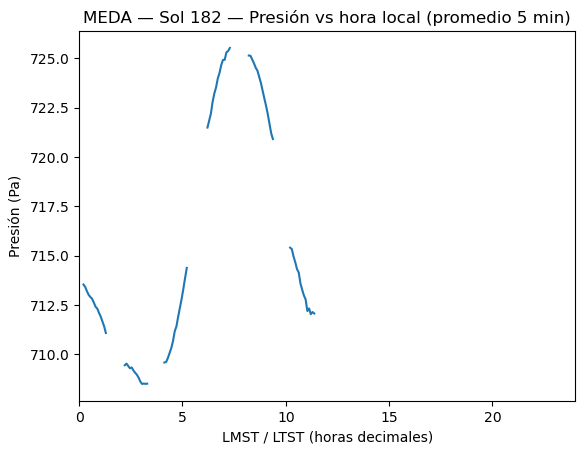

In [8]:
# Plot (lo que pide el enunciado): PRESSURE vs LTST para el sol

plt.figure()
plt.plot(df182_5min["LTST_horas"], df182_5min["PRESSURE_mean"])
plt.xlim(0, 24)
plt.xlabel("LMST / LTST (horas decimales)")
plt.ylabel("Presión (Pa)")
plt.title("MEDA — Sol 182 — Presión vs hora local (promedio 5 min)")
plt.show()


In [9]:
# Repetir lo mismo para los 4 soles (182, 361, 504, 658)
#          - genera un dataframe por sol promediado cada 5 min

dfs_5min = {}

for sol, ruta in archivos.items():
    df_raw = cargar_y_preparar_csv(sol, ruta)
    df_5 = promediar_cada_5min(df_raw, sol=sol, delta_min=5)
    dfs_5min[sol] = df_5

# Ejemplo: ver una tabla
dfs_5min[361].head()


,SOL,LTST_horas,PRESSURE_mean
0,361,0.041667,668.766181
1,361,0.125000,668.835422
2,361,0.208333,668.574058
3,361,0.291667,668.328117
4,361,0.375000,668.247411


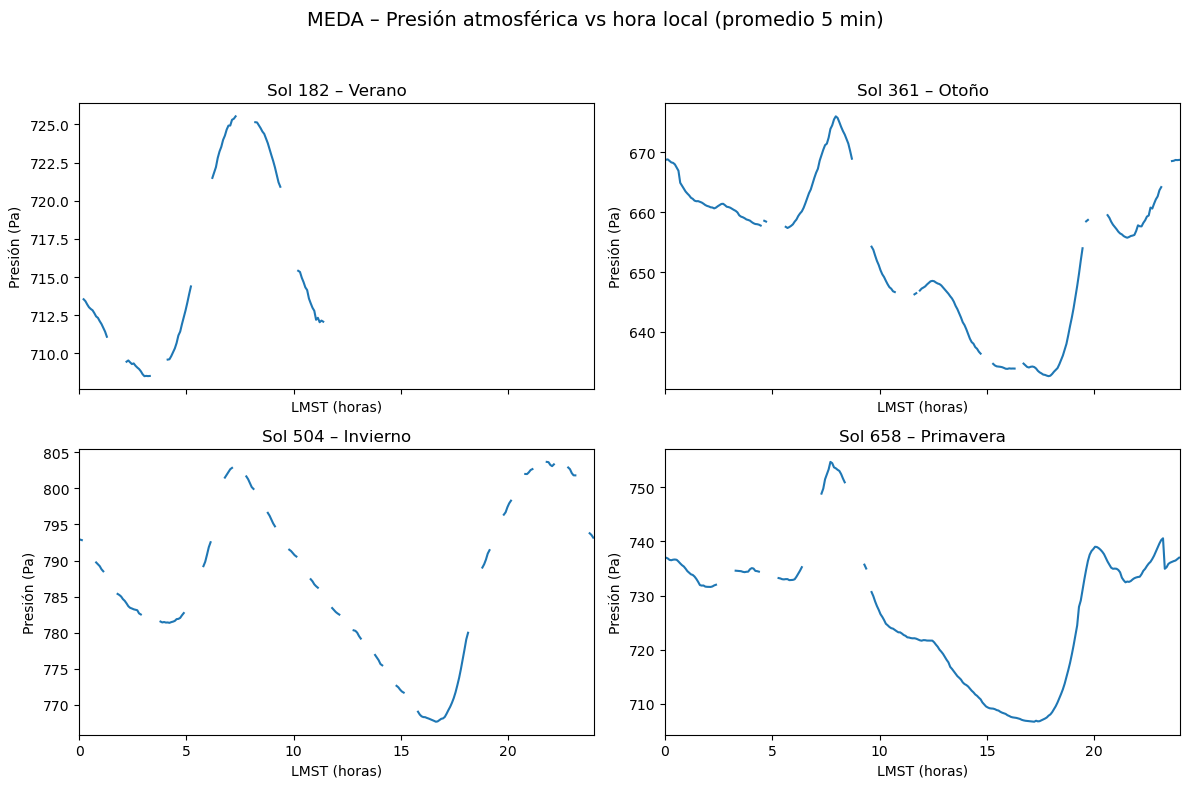

In [10]:
# Plot de los 4 soles en una matriz 2x2

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=False)

soles = [182, 361, 504, 658]
titulos = {
    182: "Sol 182 – Verano",
    361: "Sol 361 – Otoño",
    504: "Sol 504 – Invierno",
    658: "Sol 658 – Primavera"
}

for ax, sol in zip(axes.flat, soles):
    dfp = dfs_5min[sol]

    ax.plot(dfp["LTST_horas"], dfp["PRESSURE_mean"])
    ax.set_xlim(0, 24)
    ax.set_title(titulos[sol])
    ax.set_xlabel("LMST (horas)")
    ax.set_ylabel("Presión (Pa)")

fig.suptitle("MEDA – Presión atmosférica vs hora local (promedio 5 min)", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


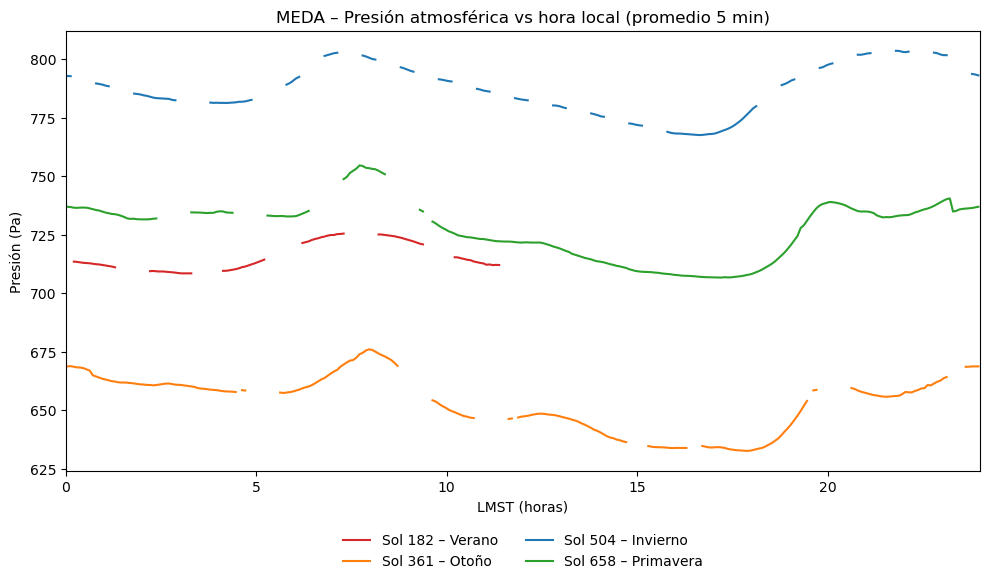

In [18]:
# 4 soles en un solo gráfico

plt.figure(figsize=(10, 6))

soles = [182, 361, 504, 658]
colores = {
    182: "tab:red",
    361: "tab:orange",
    504: "tab:blue",
    658: "tab:green"
}
labels = {
    182: "Sol 182 – Verano",
    361: "Sol 361 – Otoño",
    504: "Sol 504 – Invierno",
    658: "Sol 658 – Primavera"
}

for sol in soles:
    dfp = dfs_5min[sol]
    plt.plot(
        dfp["LTST_horas"],
        dfp["PRESSURE_mean"],
        color=colores[sol],
        label=labels[sol]
    )

plt.xlim(0, 24)
plt.xlabel("LMST (horas)")
plt.ylabel("Presión (Pa)")
plt.title("MEDA – Presión atmosférica vs hora local (promedio 5 min)")


plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -.25),
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.show()


In [11]:
# Unir todo en un solo dataframe (para tablas/resumen)

df_all_5min = pd.concat([dfs_5min[sol] for sol in [182, 361, 504, 658]], ignore_index=True)
df_all_5min.head(), df_all_5min.shape


(   SOL  LTST_horas  PRESSURE_mean
 0  182    0.041667            NaN
 1  182    0.125000            NaN
 2  182    0.208333     713.545000
 3  182    0.291667     713.421071
 4  182    0.375000     713.207240,
 (1152, 3))

In [12]:
#  Tabla resumen por sol (media y amplitud simple)

resumen = (
    df_all_5min
    .groupby("SOL")["PRESSURE_mean"]
    .agg(media="mean", p10=lambda x: np.nanpercentile(x, 10), p90=lambda x: np.nanpercentile(x, 90))
    .reset_index()
)
resumen["amplitud_p90_p10"] = resumen["p90"] - resumen["p10"]

resumen


,SOL,media,p10,p90,amplitud_p90_p10
0,182,715.694835,709.246167,724.705438,15.459271
1,361,653.546690,634.139489,668.633984,34.494495
2,504,785.529967,768.658861,802.002100,33.343239
3,658,726.648416,708.102906,738.100601,29.997695


In [13]:
import numpy as np
import pandas as pd

soles = [182, 361, 504, 658]

res = []
for sol in soles:
    dfp = dfs_5min[sol].copy()  # debe tener LTST_horas y PRESSURE_mean
    s = dfp["PRESSURE_mean"]

    p_mean = float(np.nanmean(s))
    i_max = int(np.nanargmax(s))
    i_min = int(np.nanargmin(s))

    p_max = float(s.iloc[i_max])
    t_max = float(dfp["LTST_horas"].iloc[i_max])

    p_min = float(s.iloc[i_min])
    t_min = float(dfp["LTST_horas"].iloc[i_min])

    amp = p_max - p_min

    res.append([sol, p_mean, p_max, t_max, p_min, t_min, amp])

tabla_meda = pd.DataFrame(
    res,
    columns=["SOL", "P_mean(Pa)", "P_max(Pa)", "t_max(h)", "P_min(Pa)", "t_min(h)", "Amp(Pa)"]
)

tabla_meda


,SOL,P_mean(Pa),P_max(Pa),t_max(h),P_min(Pa),t_min(h),Amp(Pa)
0,182,715.694835,725.529156,7.291667,708.507175,3.041667,17.021981
1,361,653.546690,676.027532,7.958333,632.597727,17.875000,43.429805
2,504,785.529967,803.677861,21.791667,767.654188,16.625000,36.023672
3,658,726.648416,754.673247,7.708333,706.709721,17.208333,47.963526
